<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Sentiment%20analysis%20with%20Transformer%20architecture%20(Encoder)%20and%20LSH%20(%20Locality%20Sensitive%20Hashing)%20Attention/Sentiment_analysis_with_Transformer_architecture_(Encoder)_and_LSH_(_Locality_Sensitive_Hashing)_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import re
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Dense, Dropout, Flatten, Layer, MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import string
import matplotlib.pyplot as plt
from numpy import random

In [ ]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split = ['train', 'test[:50%]', 'test[50%:]'], as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePBB9H9/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePBB9H9/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePBB9H9/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for review, label in train_ds.take(5):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

# **TEXT PREPROCESSING**

In [ ]:
batch_size = 64

In [ ]:
def standardization(input_data):
  lower_case = tf.strings.lower(input_data)
  no_html_tag = tf.strings.regex_replace(lower_case, "<[^>]+>", "")
  no_punctuations = tf.strings.regex_replace(no_html_tag, "[%s]"%re.escape(string.punctuation), "")
  output = no_punctuations
  return output

In [ ]:
#STEMMING EXAMPLE
print(PorterStemmer().stem("discussion"))
print(PorterStemmer().stem("Discussion"))
print(PorterStemmer().stem("discussing"))
print(PorterStemmer().stem("discussed"))

discuss
discuss
discuss
discuss


In [ ]:
print(PorterStemmer().stem("tensed")) #May not necessarily give a meaningful output
print(PorterStemmer().stem("tensing"))
print(PorterStemmer().stem("tension"))

tens
tens
tension


In [ ]:
sequence_length = 250
max_tokens = 10000

In [ ]:
vectorization_layer = TextVectorization(
    standardize = standardization, #Calling user defined method
    output_sequence_length = sequence_length,
    max_tokens = max_tokens,
    output_mode = 'int'
)

In [ ]:
training_data = train_ds.map(lambda x, y : x) # Takes in x (reviews) and y (labels) and outputs only x (reviews)
vectorization_layer.adapt(training_data) #Text Vectorization

In [ ]:
print(vectorization_layer.get_vocabulary())
print(len(vectorization_layer.get_vocabulary()))

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'with', 'for', 'movie', 'but', 'film', 'on', 'not', 'are', 'you', 'his', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'who', 'from', 'like', 'so', 'her', 'or', 'just', 'about', 'has', 'out', 'if', 'some', 'what', 'there', 'good', 'more', 'very', 'when', 'she', 'even', 'up', 'no', 'would', 'my', 'which', 'only', 'time', 'really', 'story', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'been', 'get', 'well', 'will', 'into', 'because', 'people', 'other', 'also', 'do', 'bad', 'great', 'how', 'first', 'most', 'him', 'dont', 'made', 'movies', 'then', 'films', 'make', 'could', 'way', 'them', 'any', 'too', 'after', 'characters', 'think', 'watch', 'two', 'many', 'being', 'seen', 'character', 'never', 'little', 'acting', 'plot', 'where', 'best', 'love', 'did', 'know', 'life', 'show', 'does', 'ever', 'your', 'better', 'over', 'still', 'off', 'end', 'these', 'sa

In [ ]:
for review,label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
#TEXT PREPROCESSING
def vectorizer(review,label):
    return vectorization_layer(review),label

train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [ ]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
train_dataset=train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# **MODELLING**

## **POSITIONAL ENCODING**

In [ ]:
def positional_encoding(d_model, sequence_length):
  outputs = []
  for pos in range(sequence_length):
    PE = np.zeros((d_model))
    for i in range(d_model):
      if i % 2 == 0:
        PE[i] = np.sin(pos / (10000 ** (i / d_model)))
      else:
        PE[i] = np.cos(pos / (10000 ** ((i - 1)/ d_model)))
    outputs.append(tf.expand_dims(PE, axis = 0)) #shape = [1, d_model]
  out = tf.concat(outputs, axis = 0) #shape = [sequence_length, d_model]
  out = tf.expand_dims(out, axis = 0) #shape = [1, sequence_length, d_model]
  return tf.cast(out, dtype = tf.float32)

In [ ]:
print(positional_encoding(256, 64).shape)

(1, 64, 256)


## **EMBEDDINGS**

In [ ]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocabulary_size, embedding_dimension):
    super(Embeddings, self).__init__()
    self.embedding = Embedding(vocabulary_size, embedding_dimension)
    self.vocabulary_size = vocabulary_size
    self.embedding_dimension = embedding_dimension
    self.sequence_length = sequence_length

  def call(self, inputs):
    embedded_tokens = self.embedding(inputs)
    embedded_positions = positional_encoding(self.embedding_dimension, self.sequence_length)
    return embedded_tokens + embedded_positions, self.compute_mask(inputs)

  def compute_mask(self, inputs, mask = None):
    mask =  tf.math.not_equal(inputs, 0) #To avoid computation for places in the sequence where value is 0 (no word) as they don't contain any info
    #True if element in inputs not equal to 0 and False if element in inputs equal to 0
    return mask


In [ ]:
mask = emb.compute_mask(test_input)
print(mask)

tf.Tensor([[ True  True  True  True  True  True False False]], shape=(1, 8), dtype=bool)


## **TRANSFORMER ENCODER**

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, embedding_dimension, inner_dense_dimension, num_heads):
    super(TransformerEncoder, self).__init__()

    self.mh_attention = MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dimension)
    #num_heads is no. of self attention units in multi head attention

    self.norm1 = LayerNormalization()
    self.norm2 = LayerNormalization()

    self.feed_forward = Sequential([
        Dense(inner_dense_dimension, activation = 'relu'),
        Dense(embedding_dimension)
    ])

  def call(self, inputs, mask = None):
    #print("transformer encoder input shape", inputs)
    if mask is not None: #mask shape = [batch_size, sequence_length]
      mask = tf.cast(mask, dtype = tf.int32) #Converting from True and False to 1 and 0
      mask1 = mask[:, :, tf.newaxis]
      mask2 = mask[:,tf.newaxis, :]
      padding_mask = tf.cast(mask1&mask2, dtype="int32")
    attention_output = self.mh_attention(key = inputs, query = inputs, value = inputs, attention_mask = padding_mask)

    add_norm_and_feed_forward_input = self.norm1(inputs + attention_output)

    feed_forward_output = self.feed_forward(add_norm_and_feed_forward_input)

    return self.norm2(add_norm_and_feed_forward_input + feed_forward_output)

## **TRANSFORMER**

In [ ]:
embedding_dimension = 128
feed_forward_inner_dimension = 1024
num_heads = 8
num_layers = 1
num_epochs = 10
vocabulary_size = max_tokens

In [ ]:
sequence_length = 250
encoder_input = Input(shape = (None,), dtype = "int64", name = "input")
embedding = Embeddings(sequence_length, vocabulary_size, embedding_dimension)
x, encoder_mask = embedding(encoder_input)

for _ in range(num_layers):
  x = TransformerEncoder(embedding_dimension, feed_forward_inner_dimension, num_heads)(x)

x = Flatten()(x)
output = Dense(1, activation = "sigmoid")(x)

transformer = tf.keras.Model(
    encoder_input, output, name = "transformer"
)
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 embeddings_1 (Embeddings)   ((None, 250, 128),        1280000   
                              (None, None))                      
                                                                 
 transformer_encoder_1 (Tra  (None, 250, 128)          791296    
 nsformerEncoder)                                                
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 32001     
                                                                 
Total params: 2103297 (8.02 MB)
Trainable params: 21032

In [ ]:
transformer.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy'])

In [ ]:
checkpoint_filepath = '/content/transformers.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True)

In [ ]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for i in train_dataset.take(2):
  print(i)

(<tf.Tensor: shape=(64, 250), dtype=int64, numpy=
array([[  10,   13,   33, ...,    0,    0,    0],
       [  11,   25,   73, ...,    0,    0,    0],
       [4799, 6235,    2, ...,    0,    0,    0],
       ...,
       [   4,  638,    3, ..., 3067,   67,   10],
       [4204,   36,   10, ...,    0,    0,    0],
       [  11,  151,  514, ...,    0,    0,    0]])>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])>)
(<tf.Tensor: shape=(64, 250), dtype=int64, numpy=
array([[2720,    1,    1, ...,  790,    9,   81],
       [ 159,  725,    1, ...,    0,    0,    0],
       [  47, 3349,  976, ...,   45,  319,   62],
       ...,
       [  11,   62,  151, ...,    0,    0,    0],
       [1650,   10,    7, ...,    0,    0,    0],
       [  45,    2, 1288, ...,    1,    7,    4]])>, <tf.Tenso

In [ ]:
history = transformer.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = num_epochs,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 63s 131ms/step - loss: 0.9849 - accuracy: 0.5051 - val_loss: 0.6920 - val_accuracy: 0.5148
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 33s 84ms/step - loss: 0.6410 - accuracy: 0.5970 - val_loss: 0.3658 - val_accuracy: 0.8373
Epoch 3/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3131 - accuracy: 0.8714 - val_loss: 0.3146 - val_accuracy: 0.8674
Epoch 4/10
391/391 [==============================] - 38s 96ms/step - loss: 0.2272 - accuracy: 0.9151 - val_loss: 0.3700 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 38s 96ms/step - loss: 0.2155 - accuracy: 0.9266 - val_loss: 0.4864 - val_accuracy: 0.8211
Epoch 6/10
391/391 [==============================] - 38s 97ms/step - loss: 0.1686 - accuracy: 0.9439 - val_loss: 0.5922 - val_accuracy: 0.8336
Epoch 7/10
391/391 [==============================] - 38s 97ms/step - loss: 0.1315 - accuracy: 0.9561 - val_loss: 0.6215 - val_accuracy: 0.8340
Epoch 8/10
391/391 [==============================] - 33s 85ms/step - loss: 0.0980 - accuracy: 0.9677 - val_loss: 0.7285 - val_accuracy: 0.8278
Epo

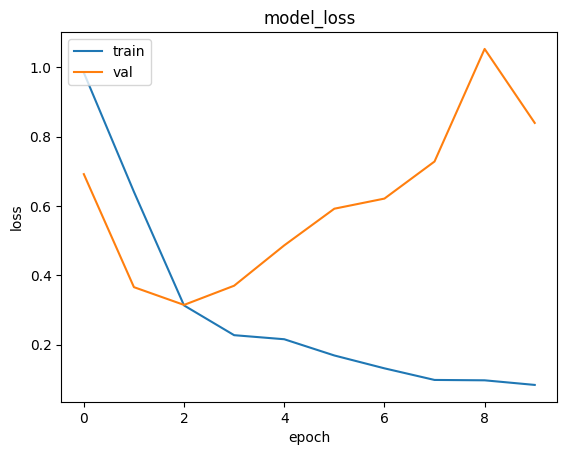

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

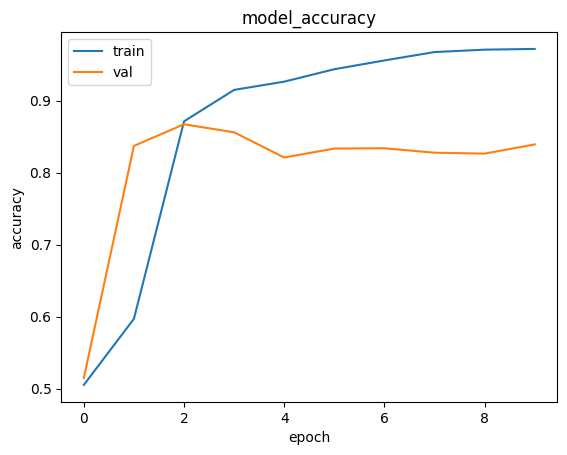

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# **TESTING**

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, so in all i liked this movie "],])


In [ ]:
def vectorizer_test(review):
    return vectorization_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [ ]:
transformer.predict(test_dataset)

2/2 [==============================] - 3s 7ms/step


array([[0.92979616],
       [0.9947237 ]], dtype=float32)

## **Inference Ready Testing**

In [ ]:
inputs = Input(shape = (1), dtype = "string")
vectorized_inputs = vectorization_layer(inputs)
outputs = transformer(vectorized_inputs)

inference_model = tf.keras.Model(inputs, outputs)
inference_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 250)               0         
 ctorization)                                                    
                                                                 
 transformer (Functional)    (None, 1)                 2103297   
                                                                 
Total params: 2103297 (8.02 MB)
Trainable params: 2103297 (8.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
inference_model.predict(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                               "very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, so in all i liked this movie "])

1/1 [==============================] - 5s 5s/step


array([[0.92979616],
       [0.9947237 ]], dtype=float32)

# **LSH Attention (Angular hash function)**

In [ ]:
def look_one_back(x): #let x be [x1, x2, x3 ... xN]
  x_extra = tf.concat([x[:, -1:, ...], x[:, :-1, ...]], axis = 1) #x_extra = [xN, x1, x2, x3 ... xN-1] #so x_extra is x shifted right by one place
  return tf.concat([x, x_extra], axis = 2) #we concat x and x_extra to get pairs of consecutive buckets an element in x_extra is the consecutive bucket of x corresponding element

def sticker_look_one_back(x): #very similar to look back function
  x_extra = tf.concat([x[:-1:], x[:, :-1]], axis = 1)
  return tf.concat([x, x_extra], axis = -1)

def causal_masker(a,b):
  '''a and b are indices of bucket elements
  To do masking here, we use the logic that if b / a > 1, b comes after a and b needs to be masked. Else, b comes before or on a and doesn't need to be masked.'''
  a, b = tf.cast(a, dtype = tf.float32) + 0.01, tf.cast(b, dtype = tf.float32) + 0.01 #To prevent zero division error or zero as the value
  vals = tf.einsum('ipj,ipk->ipjk', b, 1 / a) #b/a matrix
  out = tf.cast(tf.cast(tf.cast(vals, dtype = tf.int32), dtype = tf.bool), dtype = tf.int32) #here we have created an inverse causal mask
  out = -out + 1 #to create the required causal mask
  return tf.cast(out, dtype = tf.float32)

class LSHAttention(Layer):
    def __init__(self, bucket_size = 8, n_hashes = 1):
        super(LSHAttention, self).__init__()
        self.n_hashes = n_hashes
        self.bucket_size = bucket_size #no. of buckets

    def call(self, query, key, value, causal_masking = False):
        R = tf.random.normal((tf.shape(query)[0], #batch_size
                            tf.shape(query)[-1], #embedding_dimension
                            self.bucket_size // 2))
        xR = tf.matmul(query, R)
        concat_xR = tf.concat([xR, -xR], axis = -1)
        #concat_xR = [batch_size, sequence_length, bucket_size]
        buckets = tf.math.argmax(concat_xR, axis = -1)
        #buckets = [batch_size, sequence_length]
        # buckets tell the bucket number to which each sequence belongs to

        sticker = tf.argsort(buckets) #gives the indices of the buckets elements in ascending order
        undo_sort = tf.argsort(sticker) #original unsorted buckets elements indices with reference to the indices values in sticker

        # sequences sorted (axis = 1) based on the order in sticker
        sorted_query = tf.gather(query, sticker, axis = 1, batch_dims = 1)
        sorted_value = tf.gather(value, sticker, axis = 1, batch_dims = 1)

        chunked_query = tf.reshape(sorted_query, (tf.shape(query)[0],
                                                  self.bucket_size,
                                                  -1,
                                                  tf.shape(query)[-1])) #chunked_query = [batch_size, bucket_size, sequence_length // bucket_size, embedding_dimension]
        chunked_value = tf.reshape(sorted_value, (tf.shape(value)[0],
                                                  self.bucket_size,
                                                  -1,
                                                  tf.shape(value)[-1])) #chunked_value = [batch_size, bucket_size, sequence_length // bucket_size, embedding_dimension]

        sticker = tf.stack(tf.split(sticker, self.bucket_size, 1), 1)
        new_sticker = sticker_look_one_back(sticker)

        lb_chunked_query = look_one_back(chunked_query) #each query is linked to a previous query. This acts as the key for inter bucket attention
        #lb_chunked_query = [batch_size, bucket_size, 2 * (sequence_length // bucket_size), embedding_dimension]
        lb_chunked_value = look_one_back(chunked_value)

        score = tf.einsum('bhie,bhje->bhij', chunked_query, lb_chunked_query) #tf.linalg.matmul(query, key_transpose) in self attention
        #score = [batch_size, bucket_size, sequence_length // bucket_size, 2 * (sequence_length // bucket_size)]
        score /= tf.math.sqrt(tf.cast(query.shape[-1], tf.float32)) #normalization of score by dividing score by square root of embedding dimension

        if causal_masking == True:
            causal_mask = causal_masker(new_sticker, sticker)
            score += causal_mask * -1e-10

        score = tf.nn.softmax(score)
        output = tf.einsum('buij,buje->buie', score, lb_chunked_value)

        sorted_output = tf.reshape(output, (tf.shape(output)[0], tf.shape(query)[1], output.shape[3]))
        output=tf.gather(sorted_output, undo_sort, axis = 1, batch_dims = 1) #reordering according to original senquence order of the input
        return output